# Genetic Data Wrangling Using Julia

**Statistical Genetics Short Course**, <http://www.genetics.ucla.edu/courses/statgene/Mendel/>  
**Dr. Hua Zhou**, [huazhou@ucla.edu](mailto: huazhou@ucla.edu)  
**Department of Biostatistics, UCLA**  
**Sep 20, 2017**

This Jupyter notebook can be located at at <https://github.com/Hua-Zhou/SGSC2017Colorado/blob/master/notebooks/14_DataFormat_SnpArrays/14_Data_Wrangling.ipynb> or <https://tinyurl.com/yc32p9hb>.

In this lecture, we do some data wrangling of a genetic data set using Julia. The data set is a modified version of Mendel Option 29 (Ped-GWAS) example.

# Required packages

These Julia packages will be used in this lecture. Install them by
```julia
Pkg.add("DataFrames")
Pkg.add("Gadfly")
Pkg.add("RCall")
Pkg.clone("https://github.com/OpenMendel/SnpArrays.jl.git")
Pkg.clone("https://github.com/OpenMendel/VCFTools.jl.git")
```

# Data files

We are presented with the following files

In [81]:
;ls -l Ped29c.in SNP_def29a.in SNP_data29a_missing.bed

-rw-rw-r--  1 huazhou  staff     18868 Aug 21  2016 Ped29c.in
-rw-r--r--  1 huazhou  staff  13416483 Sep 12 10:41 SNP_data29a_missing.bed
-rw-rw-r--  1 huazhou  staff  11990931 Aug 21  2016 SNP_def29a.in


* **Pedigree file** `Ped29c.in` is directly taken from Mendel Option 29 (Ped-GWAS) example. It contains sample information, similar to the `fam` file in Plink.  
* **SNP definition file** `SNP_def29a.in` is directly taken from Mendel Option 29 (Ped-GWAS) example. It contains SNP information, similar to the `bim` file in Plink.    
* **SNP binary file** `SNP_data29a_missing.bed` is modified from the original SNP binary file `SNP_data29a.bin` by introducing misssing genotypes. It encodes genotype information in binary format, same as the `bed` file in Plink. 

Before any data analysis, it's always a good idea to know how the data is generated. Quote from the [Mendel Option 29 (Ped-GWAS) documentation (p294)](https://www.genetics.ucla.edu/software/Mendel_current_doc.pdf#page=294)  

> We constructed an example data set, 29a, that uses dense SNP data in binary files. To
simulate data with realistic linkage disequilibrium (LD) structure, we took advantage of
phased sequence data from chromosome 19 on 85 individuals of northern and western
European ancestry (originally from the CEPH sample) made publicly available in the 1000
Genomes Project [52]. After we removed markers that were mono-allelic in this set of individuals,
253,141 SNPs remained. Almost half of the SNPs have minor allele frequencies
(MAF) below 5%. The haplotype pairs attributed to the 85 CEPH members were reassigned
to the 85 founders of 27 pedigree structures selected from the Framingham Heart
Study (FHS, http://www.framinghamheartstudy.org). The selected Framingham pedigrees
were chosen to reflect the kind of pedigrees commonly collected in family-based
genetic studies. The 27 pedigrees encompass 212 people, range in size from 1 to 36 people
and from 1 to 5 generations, and contain sibships of 1 to 5 children. The genotypes of
non-founders were simulated, using Option 17, conditional on the haplotypes imposed on
the founders. All genotypes were recorded as unordered for subsequent analyses.

Note the original genotype data `SNP_data29a.bin` is complete without missing genotypes. We introduced some missingness in  the `SNP_data29a_missing.bed`.

# Explore non-genetic data

## Import pedigree file

The pedigree file `Ped29c.in` contains the sample information. Let's take a look at the first 10 lines of the file.

In [82]:
;head Ped29c.in

  1       ,  16      ,          ,          ,  F       ,          ,  30.20564,   9.24210,
  1       ,  8228    ,          ,          ,  F       ,          ,  35.82143,  15.27458,
  1       ,  17008   ,          ,          ,  M       ,          ,  36.05298,  19.50496,
  1       ,  9218    ,  17008   ,  16      ,  M       ,          ,  38.96351,  18.98575,
  1       ,  3226    ,  9218    ,  8228    ,  F       ,          ,  33.73911,  21.10412,
  2       ,  29      ,          ,          ,  F       ,          ,  34.88835,  19.01142,
  2       ,  2294    ,          ,          ,  M       ,          ,  37.70105,  19.16556,
  2       ,  3416    ,          ,          ,  M       ,          ,  45.13171,  19.84088,
  2       ,  17893   ,  2294    ,  29      ,  F       ,          ,  35.15599,  14.14228,
  2       ,  6952    ,  3416    ,  17893   ,  M       ,          ,  42.45136,  19.92713,


The columns are: **FamilyID**, **ID**, **FatherID**, **MotherID**, **Sex**, **Proband**, **SimTrait1**, **SimTrait2**, **GroupID**.

We use the [`DataFrames.jl`](https://github.com/JuliaData/DataFrames.jl) package to read in this comma separated file.

In [83]:
using DataFrames

ped29c = readtable("Ped29c.in", header = false, names = [:famid, :id, :faid, 
    :moid, :sex, :twin, :simtrait1, :simtrait2, :group])

,famid,id,faid,moid,sex,twin,simtrait1,simtrait2,group
1,1,16,NA,NA,F,NA,30.20564,9.2421,NA
2,1,8228,NA,NA,F,NA,35.82143,15.27458,NA
3,1,17008,NA,NA,M,NA,36.05298,19.50496,NA
4,1,9218,17008,16,M,NA,38.96351,18.98575,NA
5,1,3226,9218,8228,F,NA,33.73911,21.10412,NA
6,2,29,NA,NA,F,NA,34.88835,19.01142,NA
7,2,2294,NA,NA,M,NA,37.70105,19.16556,NA
8,2,3416,NA,NA,M,NA,45.13171,19.84088,NA
9,2,17893,2294,29,F,NA,35.15599,14.14228,NA
10,2,6952,3416,17893,M,NA,42.45136,19.92713,NA


`readtable` function is smart to strip the white spaces in data fields, record missing values, and *guess* the data types of each column.

In [84]:
eltypes(ped29c)

9-element Array{Type,1}:
 Int64  
 Int64  
 Int64  
 Int64  
 String 
 Int64  
 Float64
 Float64
 Int64  

## Explore phenotypes

There are two traits in the pedigree file. 

Summary statistics:

In [85]:
describe(ped29c[[:simtrait1, :simtrait2]])

simtrait1
Summary Stats:
Mean:           37.860176
Minimum:        29.240310
1st Quartile:   34.694473
Median:         37.653830
3rd Quartile:   41.589585
Maximum:        47.861930
Length:         212
Type:           Float64
Number Missing: 0
% Missing:      0.000000

simtrait2
Summary Stats:
Mean:           18.471994
Minimum:        9.242100
1st Quartile:   15.769725
Median:         18.534045
3rd Quartile:   20.840625
Maximum:        27.555420
Length:         212
Type:           Float64
Number Missing: 0
% Missing:      0.000000



Summary statistics stratified by sex.

In [86]:
by(ped29c, :sex) do df
  DataFrame(
    n = length(df[:simtrait1]),
    mean = round(mean(df[:simtrait1]), 3),
    std = round(std(df[:simtrait1]), 3)
  )
end

,sex,n,mean,std
1,F,97,34.403,2.22
2,M,115,40.776,2.728


In [87]:
by(ped29c, :sex) do df
  DataFrame(
    n = length(df[:simtrait2]),
    mean = round(mean(df[:simtrait2]), 3),
    std = round(std(df[:simtrait2]), 3)
  )
end

,sex,n,mean,std
1,F,97,16.095,2.458
2,M,115,20.477,2.674


Summary statistics stratified by pedigrees:

In [88]:
by(ped29c, :famid) do df
  DataFrame(
    n = length(df[:simtrait1]),
    mean = round(mean(df[:simtrait1]), 3),
    std = round(std(df[:simtrait1]), 3)
  )
end

,famid,n,mean,std
1,1,5,34.957,3.243
2,2,8,38.308,3.966
3,3,11,35.837,3.19
4,4,3,35.093,2.316
5,5,3,42.483,2.692
6,8,6,36.131,4.304
7,10,4,35.304,1.714
8,11,15,37.874,3.98
9,14,6,39.157,3.612
10,17,23,38.712,2.872


Graphs always help.

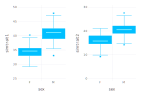

In [89]:
using Gadfly

hstack(
    plot(ped29c, x = "sex", y = "simtrait1", Geom.boxplot),
    plot(ped29c, x = "sex", y = "simtrait2", Geom.boxplot)
)

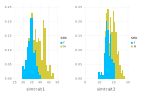

In [90]:
hstack(
    plot(ped29c, x = "simtrait1", color = "sex", Geom.histogram(bincount=20, density=true)),
    plot(ped29c, x = "simtrait2", color = "sex", Geom.histogram(bincount=20, density=true))
)

In [ ]:
plot(ped29c, x = "simtrait1", y = "simtrait2", Geom.histogram2d(xbincount=10, ybincount=10))

## Visualize pedigrees

It's desirable to visualize the pedigree structures. Although I don't know of any Julia package capable of pedigree drawing, there are a bunch of pedigree drawing software out there. See a list [here](http://www.soph.uab.edu/ssg/linkage/pedigreedrawing). Fortunately Julia makes it very easy to glue with other languages and programs. Here we show how to draw pedigress **within Julia** using the R package `kinship2`.

[`RCall.jl`](https://github.com/JuliaInterop/RCall.jl) is the Julia package that enables running R within Julia. Of course, there should be a working R on your computer and the R package `kinship2` is installed, e.g., by R command
```r
install.packages("kinship2")
```

Let's first transfer required data to R.

In [ ]:
# Pkg.add("RCall")
using RCall

id    = ped29c[:, :id]
dadid = ped29c[:, :faid]
momid = ped29c[:, :moid]
sex   = ped29c[:, :sex]
famid = ped29c[:, :famid]

@rput id dadid momid sex famid

R"""
# install.packages('kinship2', repos = 'http://cran.us.r-project.org')
library(kinship2)

ped29c = pedigree(id, dadid, momid, sex, famid = famid)
# draw pedigree with id '19'
plot(ped29c['19'])
"""

To print all pedigrees into a ps file, use a loop
```julia
R"""
# draw all pedigrees in a ps file
postscript("ped29c.ps")
for (p in 1:20) {
    plot(ped29c[p])
}
postscript()
"""
```

# Explore genetic data using SnpArrays package

## Load SNP binary file as SnpArray

To read in and manipulate the SNP binary file, which is same as the Plink bed file, we use the `SnpArrays` package, which can installed via
```julia
Pkg.clone("https://github.com/OpenMendel/SnpArrays.jl.git")
```

In [ ]:
using SnpArrays

snpbin29c = SnpArray("SNP_data29a_missing"; people = 212, snps = 253141)

`SnpArray` is an array of `Tuple{Bool,Bool}` and adopts the same coding as the [Plink binary format](http://pngu.mgh.harvard.edu/~purcell/plink/binary.shtml). If `A1` and `A2` are the two alleles, the coding rule is  

| Genotype | SnpArray |  
|:---:|:---:|  
| A1,A1 | (false,false) |  
| A1,A2 | (false,true) |  
| A2,A2 | (true,true) |  
| missing | (true,false) |  

The code `(true,false)` is reserved for missing genotype. Otherwise, the bit `true` represents one copy of allele `A2`. In a two-dimensional `SnpArray`, each row is a person and each column is a SNP.

## Summary statistics of genotypes

`summarize` function computes the following summary statistics of a `SnpArray`:  

* `maf`: minor allele frequencies, taking into account of missingness.  
* `minor_allele`: a `BitVector` indicating the minor allele for each SNP.   `minor_allele[j]==true` means A1 is the minor allele for SNP j; `minor_allele[j]==false` means A2 is the minor allele for SNP j.  
* `missings_by_snp`: number of missing genotypes for each snp.  
* `missings_by_person`: number of missing genotypes for each person.  

In [ ]:
@time maf, minor_allele, missings_by_snp, missings_by_person = summarize(snpbin29c);

How many missing genotypes in this data set?

In [ ]:
# total number of missing genotypes
sum(missings_by_snp), sum(missings_by_person)

In [ ]:
# proportion of missing genotypes
sum(missings_by_snp) / length(snpbin29c)

In [ ]:
# minor allele frequencies
maf'

In [ ]:
plot(x = maf, Geom.histogram(bincount=30), Guide.XLabel("Minor Allele Frequency"), Guide.YLabel("Count"))

## Filtering

In almost all analyses, SNPs and individuals with low genotyping success rates are ignored. This filtering step is an important tool for removing likely false positives from association testing, as genotyping failure often occurs preferentially in cases or controls, or is correlated with the quantitative trait. 
```julia
filter(snparray, min_success_rate_per_snp, min_success_rate_per_person)
``` 
does filtering according to the specified success rates for SNPs and people. Default is 0.98 for both.

In [ ]:
# filtering SNPs and people to have both success rates above 0.98
snp_idx, person_idx = filter(snpbin29c, 0.98, 0.98)

In [ ]:
# summary statistics of the filtered SnpArray
snpbin29c_filtered = snpbin29c[person_idx, snp_idx]

We see the number of SNPs is reduced from 253,141 to 237,163.

In [ ]:
_, _, missings_by_snp_filtered, missings_by_person_filtered = summarize(snpbin29c_filtered);

In [ ]:
# minimum SNP genotyping success rate after filtering ≥ 0.98
1.0 - maximum(missings_by_snp_filtered) / length(missings_by_person_filtered)

In [ ]:
# minimum individual genotyping success rate after filtering ≥ 0.98
1.0 - maximum(missings_by_person_filtered) / length(missings_by_snp_filtered)

## Subsetting SnpArray

Subsetting a SnpArray is pretty much the same as subsetting a regular array.

In [ ]:
# genotypes of the 1st person
snpbin29c[1, :]

In [ ]:
# genotypes of the 5th SNP
snpbin29c[:, 5]

In [ ]:
# subsetting both persons and SNPs
snpbin29c[1:5, 5:10]

In [ ]:
# filter out rare SNPs with MAF < 0.05
snpbin29c[:, maf .≥ 0.05]

In [ ]:
# filter out individuals with genotyping success rate < 0.90
snpbin29c[missings_by_person / size(snpbin29c, 2) .< 0.1, :]

`view()` creates views of subarray without copying data and improve efficiency in many calculations.

In [ ]:
mafcommon, = summarize(view(snpbin29c, :, maf .≥ 0.05))
mafcommon'

## Convert SnpArray to numeric array

In most analyses we convert a whole `SnpArray` or slices of it to numeric arrays (matrix of **minor allele counts**) for statistical analysis.

In [ ]:
# convert to a matrix of double precision numbers
@time snpbin29c_f64 = convert(Matrix{Float64}, snpbin29c)

We can see missing genotypes are converted to `NaN` appropriately.

In [ ]:
# number of missing genotypes
countnz(isnan.(snpbin29c)), countnz(isnan.(snpbin29c_f64))

We can also convert genotypes to a sparse matrix.

In [ ]:
# convert to SparseMatrixCSC{Float32, UInt32} matrix
@time snpbin29c_f32sp = convert(SparseMatrixCSC{Float32, UInt32}, snpbin29c)

One can enforce **crude imputation** by setting the optional argument `impute=true`. Imputation is done by generating two random alleles according to the minor allele frequency. This is a neutral but not an optimal strategy, and users should impute missing genotypes by more advanced methods.

In [ ]:
snpbin29c_f64impute = convert(Matrix{Float64}, snpbin29c; impute = true)
countnz(isnan.(snpbin29c_f64impute))

By default `convert()` translates genotypes according to the *additive* SNP model, which essentially counts the number of **minor allele** (0, 1 or 2) per genotype. Other SNP models are *dominant* and *recessive*, both in terms of the **minor allele**. When `A1` is the minor allele, genotypes are translated to real number according to

| Genotype | `SnpArray` | `model=:additive` | `model=:dominant` | `model=:recessive` |    
|:---:|:---:|:---:|:---:|:---:|  
| A1,A1 | (false,false) | 2 | 1 | 1 |  
| A1,A2 | (false,true) | 1 | 1 | 0 |  
| A2,A2 | (true,true) | 0 | 0 | 0 |  
| missing | (true,false) | NaN | NaN | NaN | 

When `A2` is the minor allele, genotypes are translated according to

| Genotype | `SnpArray` | `model=:additive` | `model=:dominant` | `model=:recessive` |    
|:---:|:---:|:---:|:---:|:---:|  
| A1,A1 | (false,false) | 0 | 0 | 0 |  
| A1,A2 | (false,true) | 1 | 1 | 0 |  
| A2,A2 | (true,true) | 2 | 1 | 1 |  
| missing | (true,false) | NaN | NaN | NaN |

In [ ]:
[convert(Vector{Float64}, snpbin29c[1:10, 5]; model = :additive) convert(Vector{Float64}, snpbin29c[1:10, 5]; model = :dominant) convert(Vector{Float64}, snpbin29c[1:10, 5]; model = :recessive)]

By default `convert()` does **not** center and scale genotypes. Setting the optional arguments `center=true, scale=true` centers genotypes at 2MAF and scales them by $[2 \cdot \text{MAF} \cdot (1 - \text{MAF})]^{-1/2}$. Mono-allelic SNPs (MAF=0) are not scaled.

In [ ]:
[convert(Vector{Float64}, snpbin29c[:, 5]) convert(Vector{Float64}, snpbin29c[:, 5]; center = true, scale = true)]

`copy!()` is the in-place version of `convert()`. Options such as GWAS loop over SNPs and perform statistical anlaysis for each SNP. This can be achieved by

In [ ]:
g = zeros(size(snpbin29c, 1))
for j = 1:size(snpbin29c, 1)
    copy!(g, snpbin29c[:, j]; model = :additive, impute = true)
    # do statistical anlaysis
end

## Empirical kinship matrix

`grm` function computes the empirical kinship matrix using either the genetic relationship matrix, `grm(A, model=:GRM)`, or the method of moment method, `grm(A, model=:MoM)`. 

!!! note

    Missing genotypes are imputed according to minor allele frequencies on the fly.  
    

By default, grm exlcude SNPs with minor allele frequency below 0.01. This can be changed by the keyword argument `maf_threshold`.

In [ ]:
# GRM using all SNPs with maf > 0.01
# same as: grm(snpbin29c; method = :GRM, maf_threshold = 0.01)
@time grm(snpbin29c)

In [ ]:
# GRM using every other SNP with maf > 0.01
@time grm(view(snpbin29c, :, 1:2:size(snpbin29c, 2)))

In [ ]:
# MoM using all SNPs with maf > 0.01
grm(snpbin29c; method = :MoM)

## Read in SNP definition file

The SNP definition file `SNP_def29a.in` contains the SNP information. 

In [ ]:
;head SNP_def29a.in

We use the Julia base function [`readcsv`](https://docs.julialang.org/en/stable/stdlib/io-network/#Base.DataFmt.readcsv) to read in the SNP definition file in a dataframe. The keyword `skipstart = 2` instructs Julia to skip the first 2 lines.

In [ ]:
## columns are: :snpid, :chrom, :pos, :allele1, :allele2, :groupname
# snpdef29c = readtable("SNP_def29a.in", skipstart = 2, header = false)
snpdef29c = readcsv("SNP_def29a.in", Any; skipstart = 2, header = false)

Unlike `readtable` in the DataFrames.jl package, `readcsv` does try to strip white spaces and infer types for each column. However, it is easy to enforce desired types on the read in data.

In [ ]:
snpid = map(x -> strip(string(x)), snpdef29c[:, 1])

In [ ]:
# chr = map(x -> string(x), snpdef29c[:, 2])
chr = convert(Vector{Int}, snpdef29c[:, 2])

In [ ]:
pos = convert(Vector{Int}, snpdef29c[:, 3])

# Explore VCF files using VCFTools.jl

VCF is a popular format for genetic data.

[VCFTools.jl](https://github.com/OpenMendel/VCFTools.jl) implements some Julia utilities for handling VCF files. The package can be installed by
```julia
Pkg.clone("https://github.com/OpenMendel/VCFTools.jl.git")
```

## Example VCF file

We will demonstrate using an example VCF file `test.08Jun17.d8b.vcf.gz`, which can be downloaded from this [link](http://faculty.washington.edu/browning/beagle/test.08Jun17.d8b.vcf.gz).

In [ ]:
;ls -l test.08Jun17.d8b.vcf.gz

The first 35 lines of the VCF file are

In [ ]:
using VCFTools

fh = openvcf("test.08Jun17.d8b.vcf.gz", "r")
for l in 1:35
    println(readline(fh))
end
close(fh)

As in typical VCF files, it has a bunch of meta-information lines, one header line, and then one line for each each marker. In this VCF, genetic data has fields GT (genotype), DS (dosage), and GL (genotype likelihood).

## Summary statistics

Number of records (markers) in a VCF file.

In [ ]:
records = nrecords("test.08Jun17.d8b.vcf.gz")

Number of samples (individuals) in a VCF file.

In [ ]:
samples = nsamples("test.08Jun17.d8b.vcf.gz")

`gtstats` function calculates genotype statistics for each marker with GT field.

In [ ]:
@time records, samples, lines, missings_by_sample, missings_by_record, 
    maf_by_record, minorallele_by_record = gtstats("test.08Jun17.d8b.vcf.gz");

In [ ]:
# number of markers
records

In [ ]:
# number of samples (individuals)
samples

In [ ]:
# number of markers with GT field
lines

In [ ]:
# number of missing genotypes in each sample (individual)
missings_by_sample'

In [ ]:
# number of missing genotypes in each marker with GT field
missings_by_record'

In [ ]:
# minor allele frequency of each marker with GT field
maf_by_record'

In [ ]:
# minor allele of each marker (with GT field): true (REF) or false (ALT)
minorallele_by_record'

The optional second argument of `gtstats` function specifies an output file or IO stream for genotype statistics per marker. Each line has fields:  
- 1-8:  VCF fixed fields (CHROM, POS, ID, REF, ALT, QUAL, FILT, INFO)
-   9:  Missing genotype count
-  10:  Missing genotype frequency
-  11:  ALT allele count
-  12:  ALT allele frequency
-  13:  Minor allele count             (REF allele vs ALT alleles)
-  14:  Minor allele frequency         (REF allele vs ALT alleles)
-  15:  HWE P-value                    (REF allele vs ALT alleles)

In [ ]:
# write genotype statistics in file gtstats.out.txt
@time gtstats("test.08Jun17.d8b.vcf.gz", "gtstats.out.txt");

In [ ]:
;ls -l gtstats.out.txt

The output file can be read as a `DataFrame` for further analysis.

In [ ]:
using DataFrames

gstat = readtable("gtstats.out.txt"; 
    header = false, 
    separator = '\t',
    names = [:chr, :pos, :id, :ref, :alt, :qual, :filt, :info, :missings, :missfreq, :nalt, :altfreq, :nminor, :maf, :hwe],
    eltypes = [String, Int, String, String, String, String, String, String, Int, Float64, Int, Float64, Int, Float64, Float64]
)

## Filter data fields in a VCF

If we are only interested in the GT data in this VCF file, we can call `filter_genotype` function for filtering.  
* The first argument is the source VCF.  
* The second argument is the output VCF.  
* The third argument is a vector of fields to output.

In [ ]:
@time filter_genotype("test.08Jun17.d8b.vcf.gz", "test.gt.vcf.gz", ["GT"])

In [ ]:
;ls -l test.gt.vcf.gz

The first 35 lines of the resultant file are

In [ ]:
fh = openvcf("test.gt.vcf.gz", "r")
for l in 1:35
    println(readline(fh))
end
close(fh)

To extract more than one fields, say GT and DS,

In [ ]:
@time filter_genotype("test.08Jun17.d8b.vcf.gz", "test.gt.ds.vcf.gz", ["GT", "DS"])

In [ ]:
;ls -l test.gt.ds.vcf.gz

The first 35 lines of the resultant file are

In [ ]:
fh = openvcf("test.gt.ds.vcf.gz", "r")
for l in 1:35
    println(readline(fh))
end
close(fh)

Note the data fields in the output file is in alphabet order, which may be different from the order in original VCF.

## Convert GT to numeric arrays

There are differnt SNP models. The *additive* SNP model essentially counts the number of **minor allele** (0, 1 or 2) per genotype. Other SNP models are *dominant* and *recessive*, both in terms of the **minor allele**. When `ALT` allele is the minor allele, genotypes are translated to real number according to

| Genotype | VCF GT | `model=:additive` | `model=:dominant` | `model=:recessive` |    
|:---:|:---:|:---:|:---:|:---:|  
| ALT,ALT | 0/0, 0&#124;0 | 2 | 1 | 1 |  
| REF,ALT | 0/1, 0&#124;1 | 1 | 1 | 0 |  
| REF,REF | 1/1, 1&#124;1 | 0 | 0 | 0 |  
| missing | . | Null | Null | Null | 

When `REF` allele is the minor allele, genotypes are translated according to

| Genotype | VCF GT | `model=:additive` | `model=:dominant` | `model=:recessive` |    
|:---:|:---:|:---:|:---:|:---:|  
| ALT,ALT | 0/0, 0&#124;0 | 0 | 0 | 0 |  
| REF,ALT | 0/1, 0&#124;1, 1/0, 1&#124;0 | 1 | 1 | 0 |  
| REF,REF | 1/1, 1&#124;1 | 2 | 1 | 1 |  
| missing | . | Null | Null | Null |

To properly record the missing genotypes, VCFTools convert VCF GT data to `NullableArray`s. Each element of a nullable array `A` is of type `Nullable{T}`. `isnull(A[i, j]) == true` indicates that `A[i, j]` is a missing genotype. See the [NullableArrays.jl](https://github.com/JuliaStats/NullableArrays.jl) package for detailed documentation. 

Convert GT data in VCF file test.08Jun17.d8b.vcf.gz to a `Nullable{Float64}` array. Impute the missing genotypes according to allele frequency, center the dosages around 2MAF, and scale the dosages by `sqrt(2MAF*(1-MAF))`.

In [ ]:
@time A = convert_gt(Float64, "test.08Jun17.d8b.vcf.gz"; model = :additive, impute = true, center = true, scale = true)

Large VCF files easily generate numeric arrays that cannot fit into computer memory. Many analyses only need to loop over markers or sets of markers. This can be achieved by the `copy_gt!` function.

* To loop over all markers in the VCF file test.08Jun17.d8b.vcf.gz:

In [ ]:
using GeneticVariation, NullableArrays, VCFTools

# initialize VCF reader
people, snps = nsamples("test.08Jun17.d8b.vcf.gz"), nrecords("test.08Jun17.d8b.vcf.gz")
reader = VCF.Reader(openvcf("test.08Jun17.d8b.vcf.gz"))
# pre-allocate vector for marker data
g = NullableArray(zeros(people))
for j = 1:snps
    copy_gt!(g, reader; model = :additive, impute = true, center = true, scale = true)
    # do statistical anlaysis
end
close(reader)

* To loop over markers in windows of size 25:

In [ ]:
using GeneticVariation, NullableArrays, VCFTools

# initialize VCF reader
people, snps = nsamples("test.08Jun17.d8b.vcf.gz"), nrecords("test.08Jun17.d8b.vcf.gz")
reader = VCF.Reader(openvcf("test.08Jun17.d8b.vcf.gz"))
# pre-allocate matrix for marker data
windowsize = 25
g = NullableArray(zeros(people, windowsize))
nwindows = ceil(Int, snps / windowsize)
for j = 1:nwindows
    copy_gt!(g, reader; model = :additive, impute = true, center = true, scale = true)
    # do statistical anlaysis
end
close(reader)

As the warning suggests, the last window has less than 25 markers. The remaining columns in the matrix `g` are set to missing values.